In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import csv
import math

In [2]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 50
spinup = 1001
spacing = 10
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

autoencoder_model = '2024-02-21/ae-2ds-32f-1l-150e-L1-0wd-0.00001l1' 
autoencoder_path = Path(f'/nobackup/smhid20/users/sm_maran/results/{autoencoder_model}/') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/results/{autoencoder_model}/')

#2024-02-21/ae-2ds-32f-1l-150e-L1-0wd-0.00001l1
mean_data_latent = -0.661827802658081
std_data_latent = 5.319980144500732

# Data Loading

In [4]:
class QGSamplesDataset(Dataset):
    def __init__(self, data_path, mode, p_train, k, spinup, spacing, iterations, mean_data, std_data, device, transform=None):
        """
        Custom Dataset for loading QG samples lazily.

        Parameters:
        - data_path (str): Path to the dataset files.
        - mode (str): Mode of the dataset to be loaded ('train', 'val', 'test').
        - p_train (float): Percentage of data to be used for training.
        - k, spinup, spacing, iterations: Parameters for data generation.
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_path = data_path
        self.data_dtype = 'float32'
        self.device = device

        self.mode = mode

        self.p_train = p_train
        self.k = k
        self.spinup = spinup
        self.spacing = spacing
        self.iterations = iterations
        self.mean_data = mean_data
        self.std_data = std_data

        self.transform = transform

        self.total_rows, self.total_columns = self._calculate_dimensions()
        self.X_indices, self.Y_indices = self._generate_indices()

        self.mmap = self.create_mmap()

    
    def create_mmap(self):
        return np.memmap(self.data_path, dtype=self.data_dtype, mode='r', shape=(self.total_rows, self.total_columns))


    def _calculate_dimensions(self):
        total_rows = self.iterations + 1
        total_columns = 4225 
        return total_rows, total_columns


    def _generate_indices(self):
        n_train = int(np.round(self.p_train * (self.total_rows - self.spinup)))  # Number of training samples
        n_val = int(np.round((1 - self.p_train) / 2 * (self.total_rows - self.spinup)))  # Number of validation samples
        # Assuming the remaining samples are used for testing

        if self.mode == 'train':
            start, stop = self.spinup, self.spinup + n_train
        elif self.mode == 'val':
            start, stop = self.spinup + n_train, self.spinup + n_train + n_val
        elif self.mode == 'test':
            start, stop = self.spinup + n_train + n_val, self.total_rows

        fit_x, fit_y = slice(start, stop - self.k), slice(start + self.k, stop)

        # Adjust indices for spacing if necessary
        X_indices = np.arange(fit_x.start, fit_x.stop)[::self.spacing]
        Y_indices = np.arange(fit_y.start, fit_y.stop)[::self.spacing]

        return X_indices, Y_indices


    def __len__(self):
        # Return the length of the dataset
        return self.X_indices.shape[0]

    def __getitem__(self, idx):
        # Calculate the actual data indices for X and Y based on the provided dataset index
        x_index = self.X_indices[idx]
        y_index = self.Y_indices[idx]

        # Access the specific samples directly from the memory-mapped array
        # This operation does not load the entire dataset into memory
        X_sample = self.mmap[x_index, :].astype(self.data_dtype)
        Y_sample = self.mmap[y_index, :].astype(self.data_dtype)

        # Normalize the samples if needed
        X_sample = (X_sample - self.mean_data) / self.std_data
        Y_sample = (Y_sample - self.mean_data) / self.std_data

        # Convert to tensors before returning
        X_sample = torch.tensor(X_sample, dtype=torch.float32).to(self.device)
        Y_sample = torch.tensor(Y_sample, dtype=torch.float32).to(self.device)

        # View the samples as 2D images
        X_sample = X_sample.view(-1, 65, 65)
        Y_sample = Y_sample.view(-1, 65, 65)

        return X_sample, Y_sample
    

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Autoencoder

In [5]:
# Fully Convolutional Autoencoder
class FullyConvolutionalAutoencoder4(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, latent_dim=100, no_downsamples=2, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(FullyConvolutionalAutoencoder4, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            self.activation,
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            dim *= 2
            encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        #encoder_layers.append(nn.Flatten(start_dim=1))
        #encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        encoder_layers.append(nn.Conv2d(in_channels=dim, out_channels=6, kernel_size=3, padding=1))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            #nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            #self.activation,
            #nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        decoder_layers.extend(self._block(6, dim, kernel_size=3, stride=1))
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2
            decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations


In [6]:
class Autoencoder(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, image_size = 65, input_channels = 1, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(Autoencoder, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation

        kernel_size = 4

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = []

        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i == self.no_downsamples:
                encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i == 0:
                decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))
            else:
                dim //= 2
                decoder_layers.extend(self._block(dim*2, dim, kernel_size=3, stride=1))
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        """
        
        x = self.encoder(x)
        activations = x
        x = self.decoder(x)
            
        return x, activations

In [7]:
import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
autoencoder.eval()

Autoencoder(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Re

In [14]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    autoencoder.eval()
    with torch.no_grad():
        for batch,_ in train_loader:
            # Get the input data from the batch
            inputs = batch#.cpu()
            latent = autoencoder.encoder(inputs)
            inputs = latent
            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)

        # Calculate the mean and standard deviation
        count = count * 256
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        print("Mean:", mean_data_latent.item())
        print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

calculate_latent_mean_std()
print(mean_data_latent, std_data_latent)

Mean: -0.661827802658081
Standard Deviation: 5.319980144500732
tensor(-0.6618, device='cuda:0') tensor(5.3200, device='cuda:0')


In [ ]:
class UNet(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, image_size = 65, input_channels = 1, isUNet = False, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(UNet, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation

        self.isUNet = isUNet
        scale = 2 if self.isUNet else 1
        kernel_size = 3 if self.isUNet else 4 # Change if not 65x65

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = []
        #if not self.isUNet:
        #    encoder_layers.append(nn.Unflatten(1, (1,self.image_size, self.image_size)))

        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i == self.no_downsamples:
                if not self.isUNet:
                    encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i == 0:
                if not self.isUNet:
                    decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim*scale, dim, kernel_size=3, stride=1)) # Change for UNet
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))
                #if not self.isUNet:
                #    decoder_layers.append(nn.Flatten(start_dim=1))
            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        """
        if self.isUNet:
            #print(x.shape)
            down_outputs = []

            for down in self.downs:
                x = down(x)
                down_outputs.append(x)
                #print(x.shape, 'down')

            activations = x

            for i, up in enumerate(self.ups):
                down_output = down_outputs.pop()
                if i > 0:
                    #print(x.shape, down_output.shape, 'up')
                    x = torch.cat([x, down_output], dim=1)
                x = up(x)
        else:
            x = self.encoder(x)
            activations = x
            x = self.decoder(x)
            
        return x, activations

In [ ]:
class Autoencoder(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(Autoencoder, self).__init__()
        self.image_size = 65
        self.input_channels = 1
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
        ]

        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=4, stride=1, batchnorm=False))
            
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2
            
            if i == self.no_downsamples:
                encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []
        
        for i in range(self.no_downsamples + 1):
            if i == 0:
                decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1)) # Unet change
            
            
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=4, padding=1))
                decoder_layers.append(nn.Flatten(start_dim=1))

            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        x = self.encoder(x)
        activations = x
        print(x.shape)
        x = self.decoder(x)
        return x, activations


# Diffusion

### Architecture

In [14]:
# Minimal U-Net
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1)
        #time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        freqs = torch.arange(half_dim, device=device)

        embeddings = math.log(10000) / (half_dim - 1)
        
        embeddings = torch.exp(freqs * - embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self, filters=16, no_downsamples=2, image_channels=1, time_emb_dim = 16):
        super().__init__()

        down_channels = [filters * 2**i for i in range(no_downsamples + 1)]
        up_channels = list(reversed(down_channels))
        out_channels = 1

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        kernel_size = 3 # Change when changing from 65x65
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.ConvTranspose2d(up_channels[-1], out_channels, kernel_size, padding=1)

    def forward(self, x, timestep, class_labels=None):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        
        if class_labels is not None:
            x = torch.cat((x, class_labels), dim=1)
        
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

simple_net = SimpleUnet()
print("Num params: ", sum(p.numel() for p in simple_net.parameters()))

Num params:  233153


In [9]:
# Old testcode
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        dim = in_ch
        
        self.layer0 = self._block(dim, dim, kernel_size=4, stride=2)
        self.layer1 = self._block(dim, dim*2, kernel_size=3, stride=1)
        self.layer2 = self._block(dim*2, dim*2, kernel_size=3, stride=1)
        
        
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]


class DenoisingUNet(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_downsamples=2, input_channels = 1, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(DenoisingUNet, self).__init__()
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.activation = activation

        # Embedding TEST
        noise_emb_dim = 32
        self.map_noise = SinusoidalPositionEmbeddings(num_channels = noise_emb_dim)

        # Change when we switch to autoencoder
        kernel_size = 4 #if self.image_size//2==0 else 4 # Change if not 65x65

        dim = self.filters
        
        # Time Embedding
        self.noise_emb = nn.Sequential(
            self.map_noise,
            nn.Linear(noise_emb_dim, noise_emb_dim),
            self.activation,
        )

        # Encoder
        self.initial_projection = nn.Sequential(*self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))

        self.downs = nn.ModuleList()
        encoder_layers = []
        
        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i != 0:
                # Add time emb here
                
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i != self.no_downsamples:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i != 0:
                decoder_layers.extend(self._block(dim*2, dim, kernel_size=3, stride=1)) # Change for UNet
            
            if i != self.no_downsamples:
                dim //= 2
                decoder_layers.extend(self._block(dim*2, dim, kernel_size=3, stride=1))
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))
            else:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    
    def forward(self, x, noise_labels):
        """
        Forward pass through the U-Net.
        """
        # Embedding
        emb = self.noise_emb(noise_labels)
        # self.affine(emb).unsqueeze(2).unsqueeze(3).to(x.dtype)
        # Down
        down_outputs = []
        for down in self.downs:
            x = down(x)
            down_outputs.append(x)

        # Up
        for i, up in enumerate(self.ups):
            down_output = down_outputs.pop()
            if i > 0:
                x = torch.cat([x, down_output], dim=1)
            x = up(x)
    
        return x

In [9]:
# Preconditioner
class GCPrecond(torch.nn.Module):
    def __init__(self, sigma_data=1, sigma_min=0.02, sigma_max=88, filters=16, no_downsamples=2, img_channels=1, img_resolution = 65):
        super(GCPrecond, self).__init__()
        self.sigma_data = sigma_data
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        
        self.img_resolution = img_resolution
        self.img_channels = img_channels

        self.model = SimpleUnet(filters=filters, no_downsamples=no_downsamples, image_channels=self.img_channels)

    def forward(self, x, sigma, class_labels=None):
        dtype = torch.float32
        x = x.to(dtype) # EMA does this
        sigma = sigma.to(dtype).reshape(-1, 1, 1, 1) # EMA does this

        # Change these if we want
        c_skip = self.sigma_data ** 2 / (sigma **2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2+ self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        F_x = self.model((c_in * x).to(dtype), c_noise.flatten(), class_labels=class_labels)
        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(dtype)
        
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)

### Loss function

In [10]:
class GCLoss:
    def __init__(self, sigma_min=0.02, sigma_max=88, rho=7, sigma_data=1):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.rho = rho
        self.sigma_data = 0.1
    
    def __call__(self, model, images, class_labels=None):
        # Sample from F inverse
        rnd_uniform = torch.rand([images.shape[0], 1, 1, 1], device=images.device)
        rho_inv = 1 / self.rho
        sigma_max_rho = self.sigma_max ** rho_inv
        sigma_min_rho = self.sigma_min ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** self.rho

        # Loss weight
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2

        # Generate noisy images
        noise = torch.randn_like(images)
        noisy_images = images + sigma * noise

        # Forward pass
        denoised_images = model(noisy_images, sigma, class_labels)

        # Compute loss
        loss = weight * ((denoised_images - images) ** 2)

        return loss.mean()


### Sampling

In [11]:
def edm_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, net.sigma_min)
    sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    xs = [x_next]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)
        
        xs.append(x_next)

    return x_next, torch.stack(xs[::-1])


In [128]:
# Redo this part
def sample_and_plot(net, class_labels = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

#sample_and_plot(model)

In [129]:
# Redo this part
def sample_and_plot_with_truth(net, class_labels = None, truth = None):
    sampler_fn = edm_sampler
    
    latents = torch.randn([1, 1, net.img_resolution, net.img_resolution], device=device)
    image, images  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    if class_labels is not None:
        images = torch.cat([truth.unsqueeze(0), images], dim=0)
    
    plt.figure(figsize=(images.shape[0], 1))
    plt.tight_layout()
    for i in range(images.shape[0]):
        plt.subplot(1, images.shape[0], i+1)
        plt.imshow(images[i,0, 0].cpu().detach().numpy())
        plt.axis('off')
    plt.show()

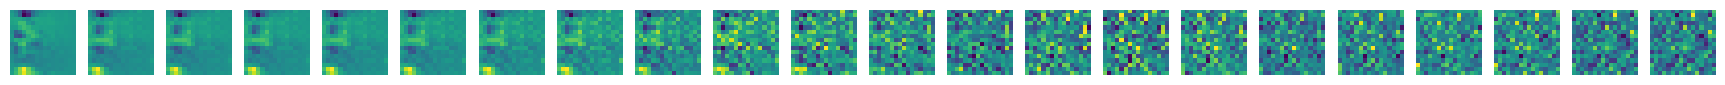

In [135]:
for previous, current in train_loader:
    with torch.no_grad():
        current_latent = autoencoder.encoder(current)
        current_latent = (current_latent - mean_data_latent) / std_data_latent

        previous_latent = autoencoder.encoder(previous)
        previous_latent = (previous_latent - mean_data_latent) / std_data_latent
    
    current_latent = current_latent[0].unsqueeze(0)
    previous_latent = previous_latent[0].unsqueeze(0)
    break
sample_and_plot_with_truth(model, class_labels = previous_latent, truth = current_latent)

In [13]:
# Redo this part
def sample_and_upsample(net, num_images = 1, class_labels=None):
    sampler_fn = edm_sampler

    latents = torch.randn([num_images, 1, net.img_resolution, net.img_resolution], device=device)
    image, _  = sampler_fn(net, latents, class_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=70, S_noise=1.05)

    with torch.no_grad():
        image = image * std_data_latent + mean_data_latent
        image = autoencoder.decoder(image.to(torch.float32))

    return image

plt.imshow(sample_and_upsample(model)[0,0].cpu().detach().numpy())
plt.axis('off')
plt.show()

AttributeError: 'SimpleUnet' object has no attribute 'img_resolution'

In [12]:
def plot_forecasts(model):
    for previous, current in train_loader:
        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            current_latent = (current_latent - mean_data_latent) / std_data_latent

            previous_latent = autoencoder.encoder(previous)
            previous_latent = (previous_latent - mean_data_latent) / std_data_latent
        
        current_latent = current_latent[0].unsqueeze(0)
        previous_latent = previous_latent[0].unsqueeze(0)
        break

    num_images = 4
    class_labels = previous_latent.repeat(num_images, 1, 1, 1)
    predicted = sample_and_upsample(model, num_images=num_images, class_labels = class_labels)

    vmin = min(predicted[0,0].cpu().detach().numpy().min(), current[0,0].cpu().detach().numpy().min(), previous[0,0].cpu().detach().numpy().min())
    vmax = max(predicted[0,0].cpu().detach().numpy().max(), current[0,0].cpu().detach().numpy().max(), previous[0,0].cpu().detach().numpy().max())

    fig, axes = plt.subplots(1, 2+num_images, figsize=(15, 5))

    axes[0].imshow(previous[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    axes[0].axis('off')
    axes[0].set_title('Previous')

    axes[1].imshow(current[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    axes[1].axis('off')
    axes[1].set_title('Truth')

    for i in range(num_images):
        axes[i+2].imshow(predicted[i,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
        axes[i+2].axis('off')
        axes[i+2].set_title('Sampled')

    plt.tight_layout()
    plt.show()

plot_forecasts(model)

NameError: name 'sample_and_upsample' is not defined

### Training

#### Generating

In [46]:
model = GCPrecond(sigma_data=1, filters=16, no_downsamples=2)
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = GCLoss()

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

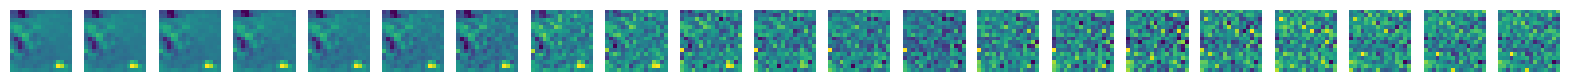

Epoch [1/10], Average Loss: 47.8304, Validation Loss: 46.7567
Training time: 99.12871s, Validation time: 11.19507s, Sample time: 0.43258s


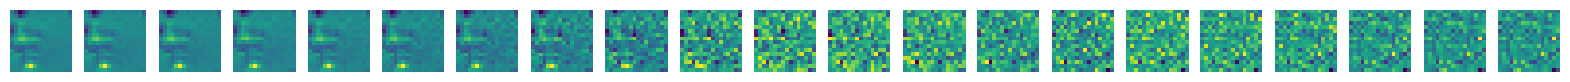

Epoch [2/10], Average Loss: 46.3050, Validation Loss: 46.2082
Training time: 108.86462s, Validation time: 11.26424s, Sample time: 0.66476s


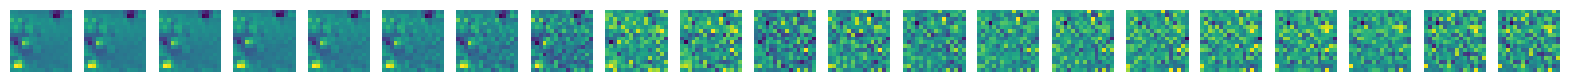

Epoch [3/10], Average Loss: 46.0982, Validation Loss: 46.0849
Training time: 109.71807s, Validation time: 12.09510s, Sample time: 0.52774s


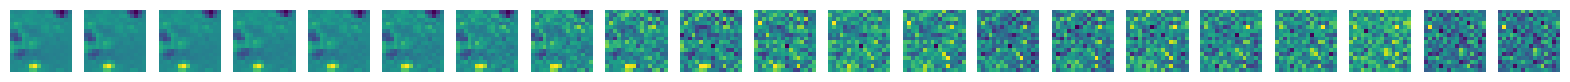

Epoch [4/10], Average Loss: 45.8722, Validation Loss: 46.1310
Training time: 110.46884s, Validation time: 11.91916s, Sample time: 0.87834s


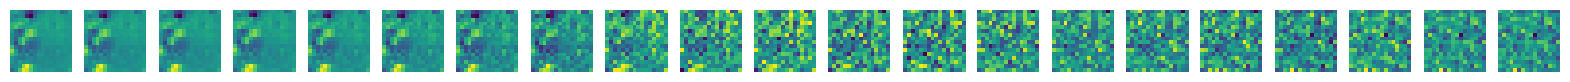

Epoch [5/10], Average Loss: 45.9015, Validation Loss: 45.6115
Training time: 114.61758s, Validation time: 12.59490s, Sample time: 0.55399s


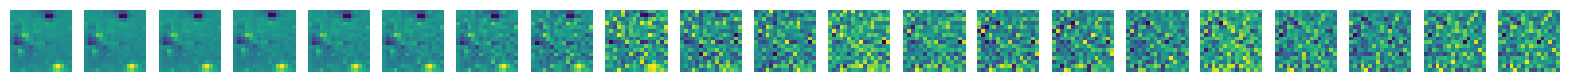

Epoch [6/10], Average Loss: 45.9355, Validation Loss: 46.1385
Training time: 117.11669s, Validation time: 11.79960s, Sample time: 0.62892s


KeyboardInterrupt: 

In [47]:
import time
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for data, _ in train_loader:
        img = data
        optimizer.zero_grad()

        
        with torch.no_grad():
            latent = autoencoder.encoder(img)
            latent = (latent - mean_data_latent) / std_data_latent
        
        
        #latent = img[:,:,:64,:64]
        
        loss = loss_fn(model, latent)

        #print(f'Loss: {loss.item(      
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data,_ in val_loader:
            img = data

            latent = autoencoder.encoder(img)
            latent = (latent - mean_data_latent) / std_data_latent
            
            loss = loss_fn(model, latent)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    # Sample and plot image
    sample_and_plot(model)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Latent: 2min 6s
Training time: 116.90123s, Validation time: 8.43696s, Sample time: 0.43425s

Original: 4min 30s
Training time: 261.16712s, Validation time: 11.05840s, Sample time: 0.59929s

#### Forecasting

In [16]:
model = GCPrecond(sigma_data=1, filters=32, no_downsamples=2, img_channels=2, img_resolution = 16)
model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = GCLoss()

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

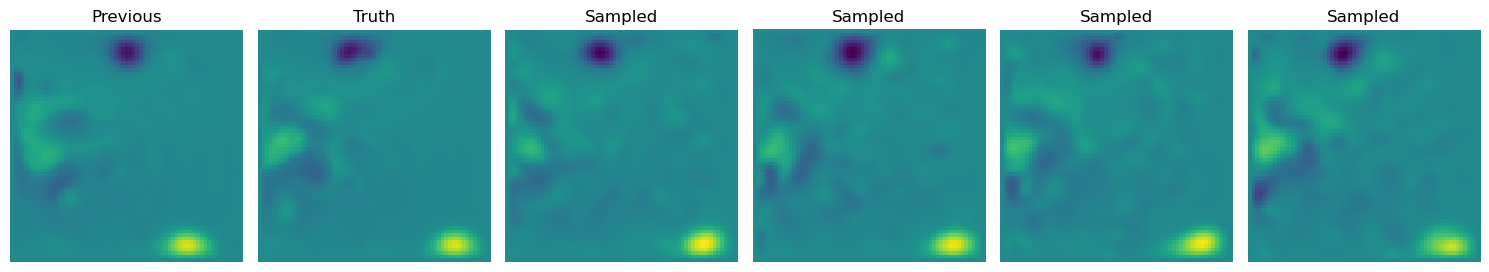

Epoch [1/30], Average Loss: 15.7266, Validation Loss: 12.2849
Training time: 184.59303s, Validation time: 21.61497s, Sample time: 0.75294s


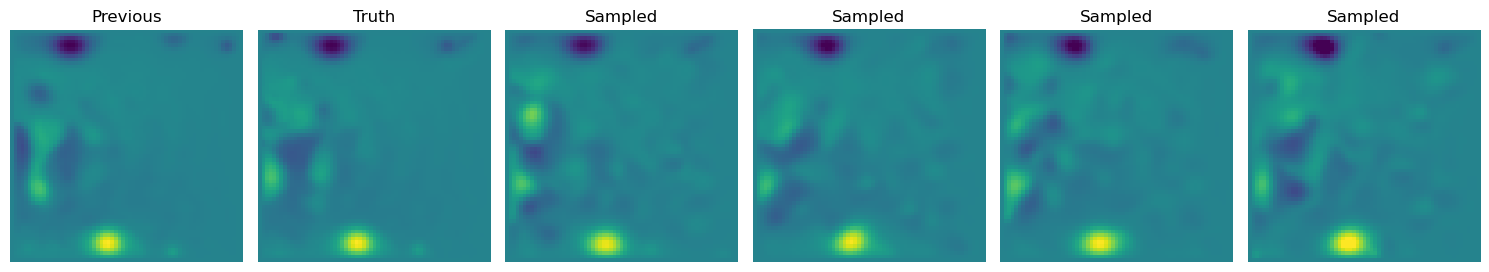

Epoch [2/30], Average Loss: 11.7225, Validation Loss: 11.4391
Training time: 151.64377s, Validation time: 16.31387s, Sample time: 0.84984s


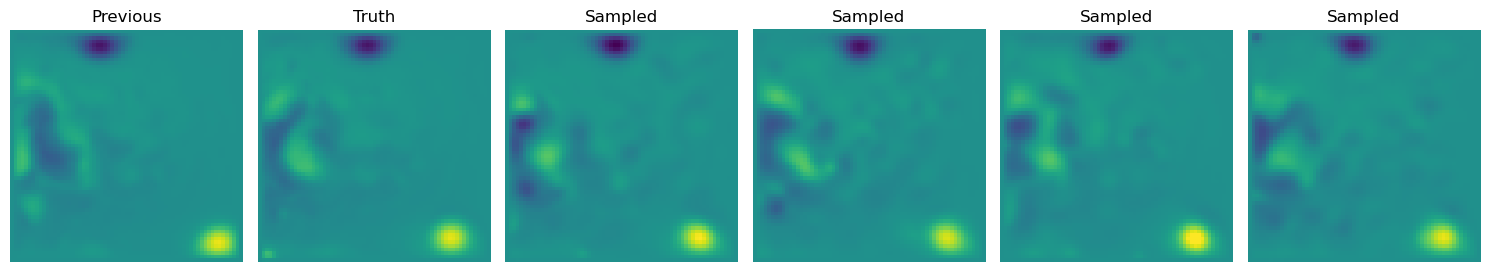

Epoch [3/30], Average Loss: 10.8772, Validation Loss: 10.7487
Training time: 151.41837s, Validation time: 16.39188s, Sample time: 0.36582s


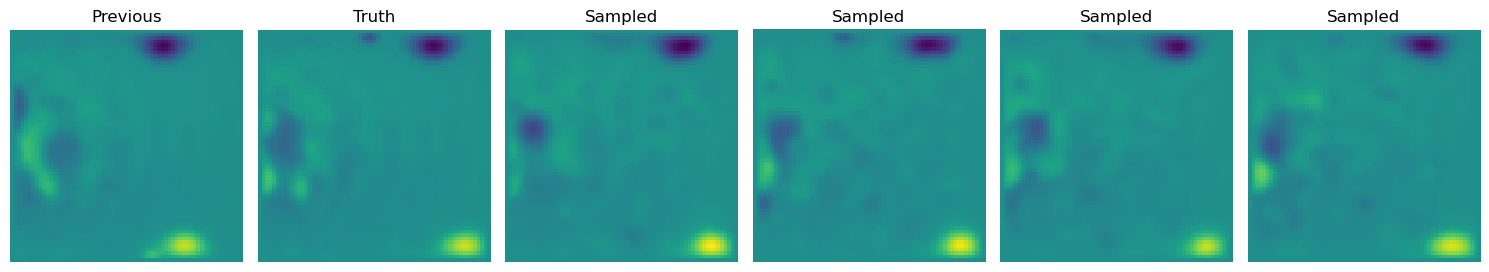

Epoch [4/30], Average Loss: 10.3927, Validation Loss: 10.3484
Training time: 151.00745s, Validation time: 16.27018s, Sample time: 0.37066s


KeyboardInterrupt: 

In [17]:
import time
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set model to training mode
    total_train_loss = 0

    for previous, current in train_loader:        
        optimizer.zero_grad()

        with torch.no_grad():
            current_latent = autoencoder.encoder(current)
            current_latent = (current_latent - mean_data_latent) / std_data_latent

            previous_latent = autoencoder.encoder(previous)
            previous_latent = (previous_latent - mean_data_latent) / std_data_latent
        
        #latent = img[:,:,:64,:64]
        
        loss = loss_fn(model, current_latent, previous_latent)

        #print(f'Loss: {loss.item(      
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    
    train_time = time.time() - start_time
    start_time = time.time()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for previous, current in val_loader:
            with torch.no_grad():
                current_latent = autoencoder.encoder(current)
                previous_latent = autoencoder.encoder(previous)
                current_latent = (current_latent - mean_data_latent) / std_data_latent
                previous_latent = (previous_latent - mean_data_latent) / std_data_latent
            
            #latent = img[:,:,:64,:64]
        
            loss = loss_fn(model, current_latent, previous_latent)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    val_time = time.time() - start_time
    start_time = time.time()
    # scheduler.step()
        
    # Sample and plot image
    #sample_and_plot(model)
    plot_forecasts(model)

    sample_time = time.time() - start_time
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    print(f'Training time: {train_time:.5f}s, Validation time: {val_time:.5f}s, Sample time: {sample_time:.5f}s')


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

### Misc

In [113]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
real_distances = []
fake_distances = []

for data, _ in val_loader:
    data = data[0]
    real_distance = np.linalg.norm(random_image - data.cpu().detach().numpy())
    fake_distance = np.linalg.norm(images[0, 0].detach().numpy() - data.cpu().detach().numpy())

    real_distances.append(real_distance)
    fake_distances.append(fake_distance)


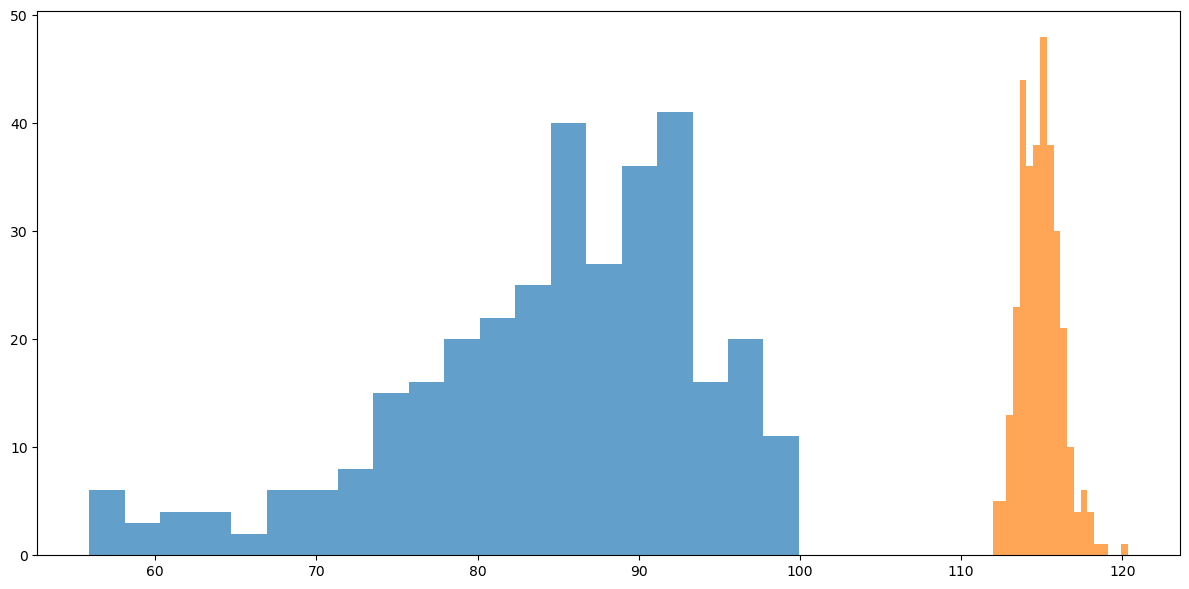

In [114]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

plt.hist(real_distances, bins=20, alpha=0.7, label='Real Images')
plt.hist(fake_distances, bins=20, alpha=0.7, label='Fake Images')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

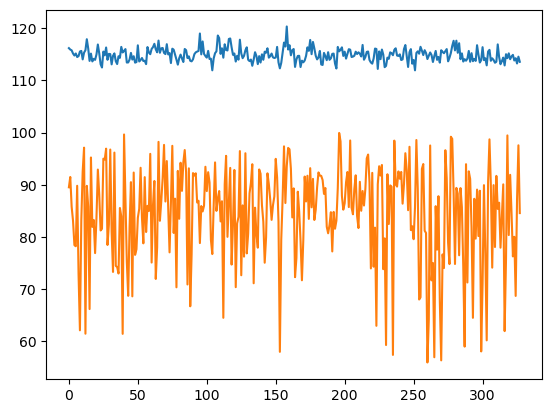

In [115]:
plt.plot(fake_distances)
plt.plot(real_distances)